In [47]:
import base64
import struct
from cobs import cobs
from collections import namedtuple
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from tqdm.notebook import tqdm
import scipy.signal

In [2]:
DataPacketDesc = {'type': 'B',
                  'size': 'B',
                  'crc16': 'H',
                  'packetID': 'I',
                  'us_start': 'I',
                  'us_end': 'I',
                  'analog': '8H',
                  'states': '8l',
                  'digitalIn': 'H',
                  'digitalOut': 'B',
                  'padding': 'x'}

DataPacket = namedtuple('DataPacket', DataPacketDesc.keys())
DataPacketStruct = '<' + ''.join(DataPacketDesc.values())
DataPacketSize = struct.calcsize(DataPacketStruct)

dtype_no_digital = [
    ('type', np.uint8),
    ('size', np.uint8),
    ('crc16', np.uint16),
    ('packetID', np.uint32),
    ('us_start', np.uint32),
    ('us_end', np.uint32),
    ('analog', np.uint16, (8, )),
    ('states', np.float32, (8, ))]
dtype_w_digital = dtype_no_digital + [('digital_in', np.uint8, (16, )), ('digital_out', np.uint8, (8, ))]

np_DataPacketType_noDigital = np.dtype(dtype_no_digital)
np_DataPacketType_withDigital = np.dtype(dtype_w_digital)

In [3]:
def count_lines(fp):
    def _make_gen(reader):
        b = reader(2**16)
        while b:
            yield b
            b = reader(2**16)
    with open(fp, 'rb') as f:
        count = sum(buf.count(b'\n') for buf in _make_gen(f.raw.read))
    return count

In [76]:
bp = Path('C:/Users/reichler/data/2021_08_09/m400061/20210809-172208_513.b64')

In [77]:
%time num_lines = count_lines(bp)
log_duration = num_lines/1000/60
print(f'{num_lines} packets, ~{log_duration:0.2f} minutes')

Wall time: 201 ms
3512208 packets, ~58.54 minutes


In [78]:
def unpack_data_packet(dp):
    s = struct.unpack(DataPacketStruct, dp)
    up = DataPacket(type=s[0], size=s[1], crc16=s[2], packetID=s[3], us_start=s[4], us_end=s[5],
                    analog=s[6:14], states=s[14:22], digitalIn=s[22], digitalOut=s[23], padding=None)
    return up

In [79]:
data = np.zeros(num_lines, dtype=np_DataPacketType_withDigital)
non_digital_names = list(np_DataPacketType_noDigital.names)

with open(bp, 'rb') as bf:
    for nline, line in enumerate(tqdm(bf, total=num_lines)):
        bl = cobs.decode(base64.b64decode(line[:-1])[:-1])
        dp = unpack_data_packet(bl)

        data[non_digital_names][nline] = np.frombuffer(bl[:-4], dtype=np_DataPacketType_noDigital)
        digital_arr = np.frombuffer(bl[-4:], dtype=np.uint8)
        data[nline]['digital_in'] = np.hstack([np.unpackbits(digital_arr[0]), np.unpackbits(digital_arr[1])])
        data[nline]['digital_out'] = np.unpackbits(np.array(digital_arr[2], dtype=np.uint8))

  0%|          | 0/3512208 [00:00<?, ?it/s]

In [80]:
# np.savez_compressed(bp.with_suffix('.npz'), data=data)
# np.save(bp.with_suffix('.npy'), arr=data)

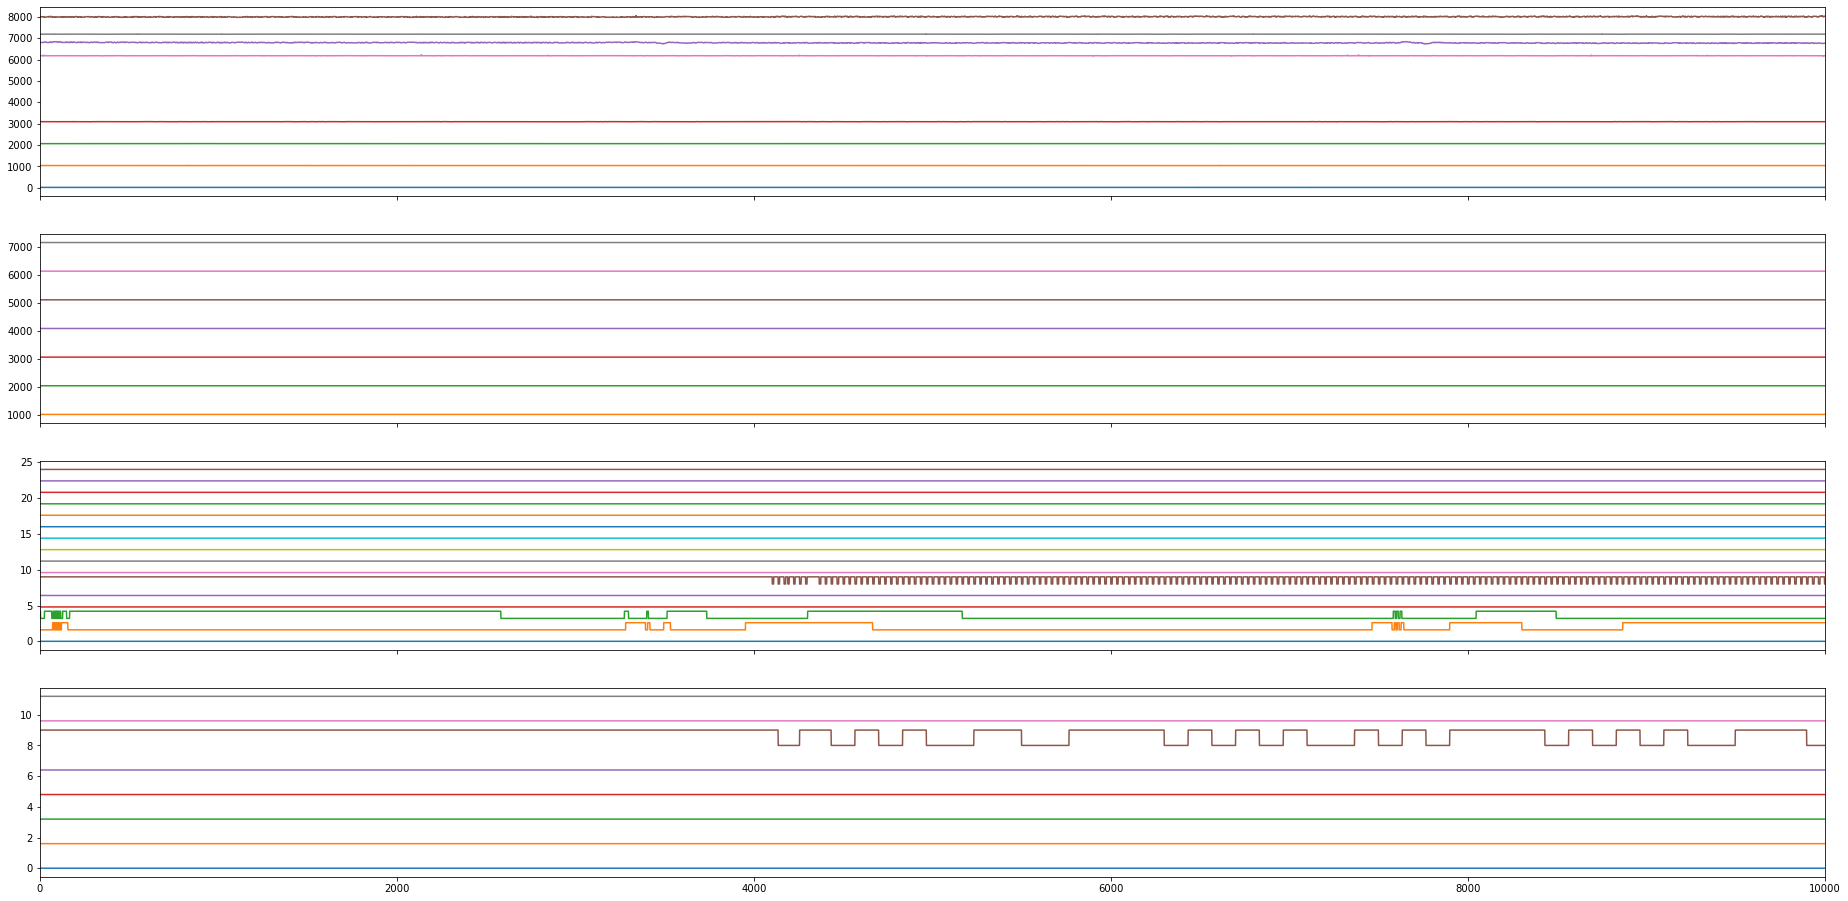

In [82]:
fig, ax = plt.subplots(4, figsize=(32, 16), sharex=True)
start, end = 0, 10000
for n in range(8):
    ax[0].plot(data['analog'][start:end, n]+n*1024)
    ax[1].plot(data['states'][start:end, n]+n*1024)
    ax[3].plot(data['digital_out'][start:end, n]+n*1.6)

for n in range(16):
    ax[2].plot(data['digital_in'][start:end, n]+n*1.6)
    ax[2].set_xlim(start, end)

## Check for packetID jumps

In [83]:
jumps = np.unique(np.diff(data['packetID']))
assert(len(jumps) and jumps[0] == 1)

# Lick Detection

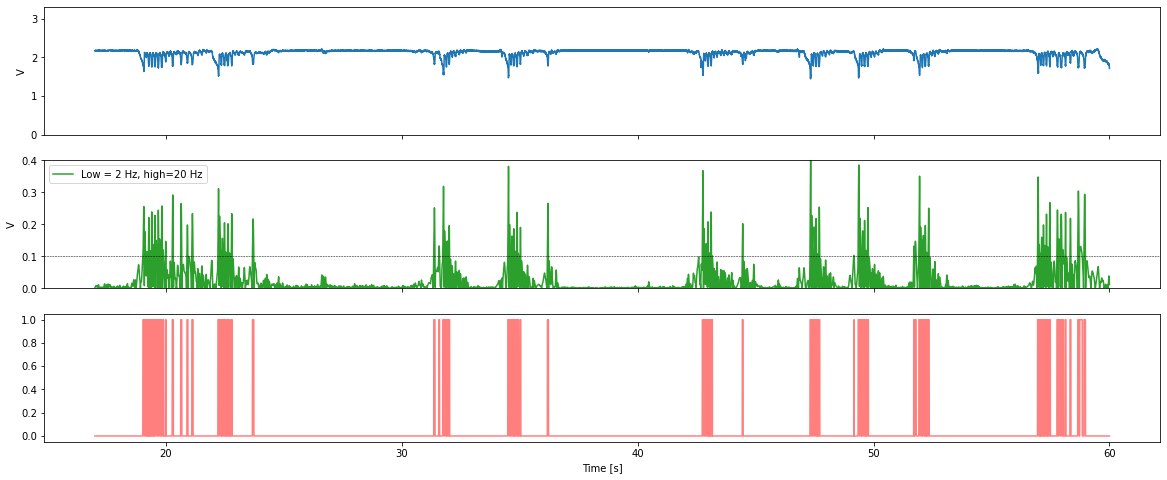

In [162]:
fs = 1000

start, end = 17*fs, 60*fs

lo, hi = 2, 20
b, a = scipy.signal.butter(3, [2*lo/fs, 2*hi/fs], 'band')
uVolt = 3.3/4096

threshold = 0.1


t = np.linspace(start, end, (end-start))/fs
filtered = np.abs(scipy.signal.filtfilt(b, a, data['analog'][start:end, 4]))*uVolt

fig, ax = plt.subplots(3, figsize=(20, 8), sharex=True)
ax[0].plot(t, data['analog'][start:end, 4]*uVolt, c=f'C{0}')
ax[0].set_ylim(0, 3.3)
ax[0].set_ylabel('V')
ax[1].plot(t, filtered, c=f'C{2}', alpha=1, label=f'Low = {lo} Hz, high={hi} Hz')

ax[1].set_ylim(0, 0.400)
ax[1].axhline(threshold, c='k', linestyle='--', linewidth=0.5)
ax[1].set_ylabel('V')
ax[1].legend()

ax[2].plot(t, filtered > threshold, c='r', alpha=0.5)
ax[2].set_xlabel('Time [s]');